# A/B Тест Отчет

## Введение
Наша команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

С помощью серии статистических тестов мы оценим, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. 

## Описание данных
Наш набор данных состоит из:

    ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
    ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
    ab_products – подробная информация о продуктах, их название и стоимость

## Разведочный анализ данных
Для начала загрузим данные и проведем первоначальное исследование, чтобы понять их структуру и содержание.

In [3]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [4]:
def read_file(href: str, parse_dates=None) -> pd.DataFrame:
    """
    Функция возвращает считанный датафрейм по публичной ссылке на файл.
    
    :param href: Публичная ссылка на файл
    :param parse_dates: Список колонок, которые нужно преобразовать в даты
    :return: DataFrame, считанный из файла
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = f"{base_url}public_key={href}"
    response = requests.get(final_url)
    
    download_url = response.json()['href']
    
    return pd.read_csv(download_url, parse_dates=parse_dates)

In [5]:
ab_users_data = read_file('https://disk.yandex.ru/d/4qY27tJ23G_B1g')
ab_orders = read_file('https://disk.yandex.ru/d/prdO8FDQx7lzCg')
ab_products = read_file('https://disk.yandex.ru/d/atwrlmB_wu-fHA')

In [6]:
#ab_users_data = pd.read_csv('ab_users_data.csv').query('action == "create_order"') # Для моих метрик нужны будут только совершенные заказы

In [7]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [4]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [5]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


## Статистический анализ

Чтобы оценить, правда ли, что новый алгоритм улучшил эффективность системы рекомендаций необходимо провести статистический анализ. 

## Средний чек
Данная метрика отвечает за среднюю сумму заказа на пользователя

Нулевая гипотеза (𝐻₀): Нет различий в среднем чеке между пользователями с новой системой рекомендаций и пользователями со старой версией приложения.

𝐻₀: μ₀ = μ₁

Альтернативная гипотеза (𝐻₁): Существуют различия в среднем чеке между пользователями с новой системой рекомендаций и пользователями со старой версией приложения.

𝐻₁: μ₀ ≠ μ₁

In [6]:
ab_orders_expanded = ab_orders.copy()

ab_orders_expanded['product_ids'] = ab_orders_expanded['product_ids'].apply(lambda x: 
                                                                            list(map(int, x.strip('{}').split(', ')))
                                                                           )

ab_orders_expanded = ab_orders_expanded.explode('product_ids')

ab_orders_expanded = ab_orders_expanded.merge(ab_products, left_on='product_ids', right_on='product_id')

ab_orders_total = ab_orders_expanded.groupby('order_id')['price'].sum().reset_index(name='total_price')

ab_user_orders = ab_users_data.merge(ab_orders_total, on='order_id')

user_avg_check = ab_user_orders.groupby('user_id').agg(
    total_spent=('total_price', 'sum'),
    order_count=('order_id', 'nunique')
).reset_index()
user_avg_check['avg_check'] = user_avg_check['total_spent'] / user_avg_check['order_count']

user_avg_check = user_avg_check.merge(ab_users_data[['user_id', 'group']].drop_duplicates(), on='user_id')

In [7]:
group_0 = ab_user_orders[ab_user_orders['group'] == 0]['total_price']
group_1 = ab_user_orders[ab_user_orders['group'] == 1]['total_price']

t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)

t_stat, p_value

(1.4835135849437482, 0.1380295748494135)

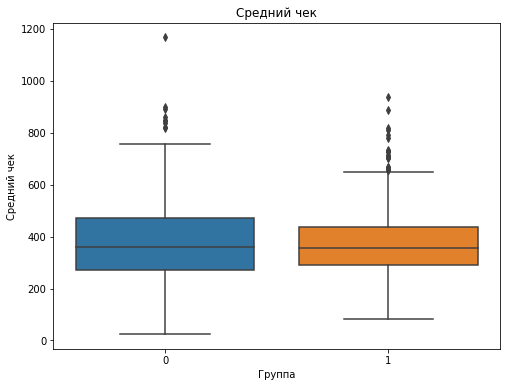

In [8]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=user_avg_check, x='group', y='avg_check')
plt.title('Средний чек')
plt.xlabel('Группа')
plt.ylabel('Средний чек')
plt.show()

Так как p-значение больше типичного уровня значимости 0.05, мы не можем отвергнуть нулевую гипотезу о том, что средние чеки между двумя группами не отличаются. Это означает, что на основании имеющихся данных **нет статистически значимых доказательств того, что новая система рекомендаций повлияла на средний чек заказа.**

## Количество товаров в заказе
Данная метрика отвечает за среднее количество товаров в одном заказе.

Нулевая гипотеза (𝐻₀): Нет различий в среднем количестве товаров в одном заказе между пользователями с новой системой рекомендаций и пользователями со старой версией приложения.

𝐻₀: μ₀ = μ₁

Альтернативная гипотеза (𝐻₁): Существуют различия в среднем количестве товаров в одном заказе между пользователями с новой системой рекомендаций и пользователями со старой версией приложения.

𝐻₁: μ₀ ≠ μ₁

In [9]:
ab_orders_expanded['product_count'] = ab_orders_expanded.groupby('order_id')['product_ids'].transform('count')

ab_orders_product_count = ab_orders_expanded[['order_id', 'product_count']].drop_duplicates()

ab_user_orders_product_count = ab_users_data.merge(ab_orders_product_count, on='order_id')

group_0_count = ab_user_orders_product_count[ab_user_orders_product_count['group'] == 0]['product_count']
group_1_count = ab_user_orders_product_count[ab_user_orders_product_count['group'] == 1]['product_count']

t_stat_count, p_value_count = ttest_ind(group_0_count, group_1_count, equal_var=False)

t_stat_count, p_value_count

(-0.13855604538771835, 0.8898090205669105)

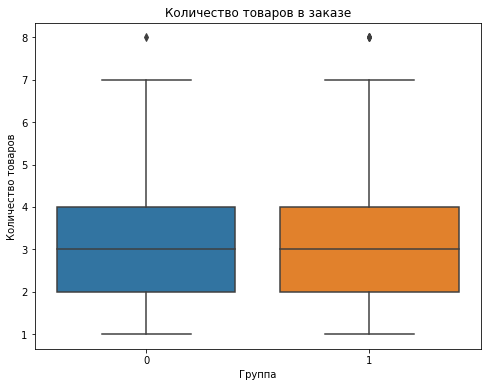

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=ab_user_orders_product_count, x='group', y='product_count')
plt.title('Количество товаров в заказе')
plt.xlabel('Группа')
plt.ylabel('Количество товаров')
plt.show()

Так как p-значение значительно больше уровня значимости 0.05, мы не можем отвергнуть нулевую гипотезу о том, что среднее количество товаров в заказе между двумя группами не отличается. Это означает, что на основании имеющихся данных **нет статистически значимых доказательств того, что новая система рекомендаций повлияла на среднее количество товаров в заказе.**

## Средняя стоимость товара в заказе

Данная метрика отвечает за среднюю стоимость одного товара в заказе.

Нулевая гипотеза (𝐻₀): Нет различий в средней стоимости одного товара в заказе между пользователями с новой системой рекомендаций и пользователями со старой версией приложения.

𝐻₀: μ₀ = μ₁

Альтернативная гипотеза (𝐻₁): Существуют различия в средней стоимости одного товара в заказе между пользователями с новой системой рекомендаций и пользователями со старой версией приложения.

𝐻₁: μ₀ ≠ μ₁

In [11]:
ab_orders_expanded['average_price_per_product'] = ab_orders_expanded.groupby('order_id')['price'].transform('mean')

ab_orders_avg_price = ab_orders_expanded[['order_id', 'average_price_per_product']].drop_duplicates()

ab_user_orders_avg_price = ab_users_data.merge(ab_orders_avg_price, on='order_id')

group_0_avg_price = ab_user_orders_avg_price[ab_user_orders_avg_price['group'] == 0]['average_price_per_product']
group_1_avg_price = ab_user_orders_avg_price[ab_user_orders_avg_price['group'] == 1]['average_price_per_product']

t_stat_avg_price, p_value_avg_price = ttest_ind(group_0_avg_price, group_1_avg_price, equal_var=False)

t_stat_avg_price, p_value_avg_price

(2.1988295427870894, 0.02795858139752931)

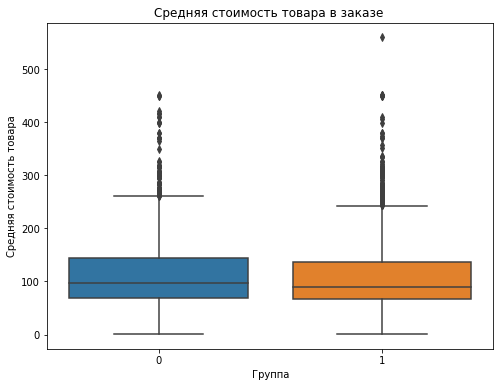

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=ab_user_orders_avg_price, x='group', y='average_price_per_product')
plt.title('Средняя стоимость товара в заказе ')
plt.xlabel('Группа')
plt.ylabel('Средняя стоимость товара')
plt.show()

Так как p-значение меньше уровня значимости 0.05, мы можем отвергнуть нулевую гипотезу и сделать вывод, что есть статистически значимые различия в средней стоимости одного товара в заказе между двумя группами. Это означает, что **новая система рекомендаций оказала влияние на среднюю стоимость товаров в заказе.**

## Частота покупок
Данная метрика отвечает за среднее количество заказов на одного пользователя за период теста.

Нулевая гипотеза (𝐻₀): Нет различий в частоте покупок между пользователями с новой системой рекомендаций и пользователями со старой версией приложения.

𝐻₀: μ₀ = μ₁

Альтернативная гипотеза (𝐻₁): Существуют различия в частоте покупок между пользователями с новой системой рекомендаций и пользователями со старой версией приложения

𝐻₁: μ₀ ≠ μ₁

In [13]:
user_order_count = ab_users_data \
.groupby(['user_id', 'group']).size().reset_index(name='order_count')

group_0_order_count = user_order_count[user_order_count['group'] == 0]['order_count']
group_1_order_count = user_order_count[user_order_count['group'] == 1]['order_count']

t_stat_order_count, p_value_order_count = ttest_ind(group_0_order_count, group_1_order_count, equal_var=False)

t_stat_order_count, p_value_order_count

(-14.485156769858916, 2.9077831935473898e-43)

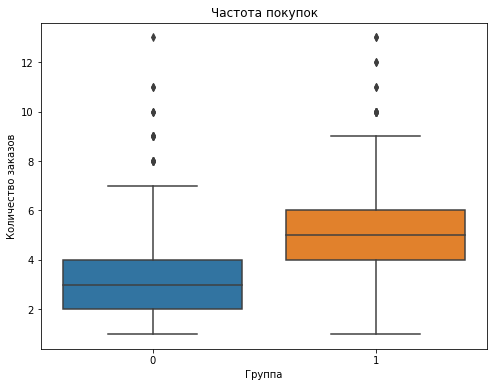

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=user_order_count, x='group', y='order_count')
plt.title('Частота покупок')
plt.xlabel('Группа')
plt.ylabel('Количество заказов')
plt.show()

Так как p-значение значительно меньше уровня значимости 0.05, мы можем отвергнуть нулевую гипотезу и сделать вывод, что есть статистически значимые различия в частоте покупок между двумя группами. Это означает, что **новая система рекомендаций оказала значительное влияние на среднее количество заказов на одного пользователя.**

# Результат

Новая система рекомендаций значительно увеличивает частоту покупок, что является положительным результатом для бизнеса. Однако различия в среднем чеке и количестве товаров в заказе не являются статистически значимыми. Средняя стоимость товара в заказе показывает значимые различия между группами, что может свидетельствовать о влиянии новой системы рекомендаций на выбор товаров.

## Рекомендации:

Продолжить использование новой системы рекомендаций, так как она значительно увеличивает частоту покупок.
Необходимо провести дополнительные исследования, чтобы понять, как система рекомендаций влияет на выбор товаров и стоимость заказа.